In [1]:
"""
YOUTUBE TREND PREDICTION 
Omar Mokhtar - 22040301145
TrendHunters Team

ÖNEMLİ DEĞİŞİKLİKLER:
1. Data leakage düzelttim (view_count -> is_trending ilişkisi)
2. Gereksiz feature'lar temizlendi
3. Advanced modeller optimize edildi
4. Hyperparameter tuning ekledim
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import pickle
import time
import os
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                                roc_auc_score, confusion_matrix, classification_report, roc_curve,
                                precision_recall_curve, average_precision_score)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

os.makedirs('results_final', exist_ok=True)
os.makedirs('saved_models', exist_ok=True)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Veri yukleme
file_path = r'C:\Users\omer\Desktop\Youtube Videos Trend Project\processed_data\youtube_data_featured.csv'
df = pd.read_csv(file_path)
print(f"Veri yuklendi: {df.shape[0]:,} satir x {df.shape[1]} sutun")

target = 'is_trending'
print(f"\nHedef degisken: {target}")
print(f"Class 0 (Non-Trending): {(df[target]==0).sum():,} ({(df[target]==0).mean()*100:.1f}%)")
print(f"Class 1 (Trending): {(df[target]==1).sum():,} ({(df[target]==1).mean()*100:.1f}%)")


Veri yuklendi: 395,915 satir x 49 sutun

Hedef degisken: is_trending
Class 0 (Non-Trending): 218,383 (55.2%)
Class 1 (Trending): 177,532 (44.8%)


In [3]:
# HUCRE 3: Feature Engineering - Baslangic
print("\n### FEATURE ENGINEERING BASLIYOR ###")

df_features = df.copy()
new_feat_count = 0

print("Her adimda eklenen feature'lar raporlanacak...")



### FEATURE ENGINEERING BASLIYOR ###
Her adimda eklenen feature'lar raporlanacak...


In [4]:
# HUCRE 4: Channel Features
print("\n[1/8] Channel Features...")

if 'channelTitle' in df_features.columns:
    df_features['channel_official'] = df_features['channelTitle'].fillna('').str.upper().str.contains(
        'OFFICIAL|VEVO|VERIFIED', regex=True).astype(int)
    df_features['channel_name_len'] = df_features['channelTitle'].fillna('').str.len()
    df_features['channel_single_word'] = (df_features['channelTitle'].fillna('').str.split().str.len() == 1).astype(int)
    new_feat_count += 3
    print(f"  Eklendi: 3 feature (channel_official, channel_name_len, channel_single_word)")
    print(f"  Toplam: {new_feat_count}")



[1/8] Channel Features...
  Eklendi: 3 feature (channel_official, channel_name_len, channel_single_word)
  Toplam: 3


In [5]:
# HUCRE 5: Title Features
print("\n[2/8] Title Features...")

if 'title' in df_features.columns:
    power_words = ['FREE', 'NEW', 'BEST', 'TOP', 'HOW', 'EASY', 'ULTIMATE', 'PERFECT']
    viral_words = ['SHOCKING', 'AMAZING', 'INCREDIBLE', 'UNBELIEVABLE', 'INSANE', 'CRAZY']
    
    df_features['title_power_words'] = df_features['title'].fillna('').str.upper().apply(
        lambda x: sum(1 for w in power_words if w in x))
    df_features['title_viral_words'] = df_features['title'].fillna('').str.upper().apply(
        lambda x: sum(1 for w in viral_words if w in x))
    df_features['title_has_year'] = df_features['title'].fillna('').str.contains('202[0-9]', regex=True).astype(int)
    df_features['title_starts_number'] = df_features['title'].fillna('').str.match(r'^\d+').astype(int)
    df_features['title_optimal_len'] = df_features['title_length'].apply(lambda x: 1 if 40 <= x <= 70 else 0)
    df_features['title_caps_balanced'] = df_features.get('title_caps_ratio', 0).apply(
        lambda x: 1 if 0.1 <= x <= 0.4 else 0)
    
    title_feat = 6
    new_feat_count += title_feat
    print(f"  Eklendi: {title_feat} feature (power_words, viral_words, has_year, starts_number, optimal_len, caps_balanced)")
    print(f"  Toplam: {new_feat_count}")



[2/8] Title Features...
  Eklendi: 6 feature (power_words, viral_words, has_year, starts_number, optimal_len, caps_balanced)
  Toplam: 9


In [6]:
# HUCRE 6: Content Type Detection
print("\n[3/8] Content Type Features...")

if 'title' in df_features.columns and 'description' in df_features.columns:
    def detect_type(title, desc, keywords):
        text = (str(title) + ' ' + str(desc)).upper()
        return 1 if any(k in text for k in keywords) else 0
    
    df_features['content_tutorial'] = df_features.apply(
        lambda r: detect_type(r.get('title',''), r.get('description',''), 
        ['HOW TO', 'TUTORIAL', 'GUIDE', 'LEARN', 'TIPS']), axis=1)
    
    df_features['content_review'] = df_features.apply(
        lambda r: detect_type(r.get('title',''), r.get('description',''), 
        ['REVIEW', 'UNBOXING', 'VS', 'COMPARISON']), axis=1)
    
    df_features['content_fun'] = df_features.apply(
        lambda r: detect_type(r.get('title',''), r.get('description',''), 
        ['FUNNY', 'PRANK', 'CHALLENGE', 'REACTION']), axis=1)
    
    df_features['content_news'] = df_features.apply(
        lambda r: detect_type(r.get('title',''), r.get('description',''), 
        ['BREAKING', 'NEWS', 'UPDATE', 'LEAKED']), axis=1)
    
    df_features['content_gaming'] = df_features.apply(
        lambda r: detect_type(r.get('title',''), r.get('description',''), 
        ['GAME', 'GAMING', 'GAMEPLAY', 'PLAY']), axis=1)
    
    content_feat = 5
    new_feat_count += content_feat
    print(f"  Eklendi: {content_feat} feature (tutorial, review, fun, news, gaming)")
    print(f"  Toplam: {new_feat_count}")



[3/8] Content Type Features...
  Eklendi: 5 feature (tutorial, review, fun, news, gaming)
  Toplam: 14


In [7]:
# HUCRE 7: Publishing Strategy
print("\n[4/8] Publishing Strategy Features...")

df_features['optimal_hour'] = df_features['publish_hour'].apply(lambda x: 1 if 14 <= x <= 20 else 0)
df_features['prime_time'] = df_features['publish_hour'].apply(lambda x: 1 if 18 <= x <= 21 else 0)
df_features['morning_upload'] = df_features['publish_hour'].apply(lambda x: 1 if 6 <= x <= 11 else 0)
df_features['weekday_good'] = df_features['publish_dayofweek'].apply(lambda x: 1 if 1 <= x <= 4 else 0)
df_features['friday_upload'] = df_features['publish_dayofweek'].apply(lambda x: 1 if x == 4 else 0)
df_features['summer'] = df_features['publish_month'].apply(lambda x: 1 if 6 <= x <= 8 else 0)
df_features['holiday'] = df_features['publish_month'].apply(lambda x: 1 if x in [11,12] else 0)
df_features['new_year'] = df_features['publish_month'].apply(lambda x: 1 if x in [1,2] else 0)

publish_feat = 8
new_feat_count += publish_feat
print(f"  Eklendi: {publish_feat} feature (optimal_hour, prime_time, morning, weekday, friday, summer, holiday, new_year)")
print(f"  Toplam: {new_feat_count}")



[4/8] Publishing Strategy Features...
  Eklendi: 8 feature (optimal_hour, prime_time, morning, weekday, friday, summer, holiday, new_year)
  Toplam: 22


In [8]:
# HUCRE 8: Metadata Quality
print("\n[5/8] Metadata Quality Features...")

df_features['meta_complete'] = (
    (df_features['title_length'] > 10) &
    (df_features['description_length'] > 100) &
    (df_features['tags_count'] > 3)
).astype(int)

df_features['meta_professional'] = (
    (df_features['description_length'] > 300) &
    (df_features['description_has_link'] == 1) &
    (df_features['tags_count'] >= 5)
).astype(int)

df_features['meta_balanced'] = (
    (df_features['title_length'] >= 30) &
    (df_features['title_length'] <= 70) &
    (df_features['tags_count'] >= 5) &
    (df_features['tags_count'] <= 15)
).astype(int)

df_features['seo_optimized'] = (
    (df_features['description_has_hashtag'] == 1) &
    (df_features['description_has_link'] == 1) &
    (df_features['tags_count'] >= 7)
).astype(int)

df_features['minimal_effort'] = (
    (df_features['description_length'] < 100) &
    (df_features['tags_count'] < 5)
).astype(int)

df_features['detailed_desc'] = (df_features['description_length'] > 500).astype(int)

meta_feat = 6
new_feat_count += meta_feat
print(f"  Eklendi: {meta_feat} feature (complete, professional, balanced, seo, minimal_effort, detailed_desc)")
print(f"  Toplam: {new_feat_count}")


[5/8] Metadata Quality Features...
  Eklendi: 6 feature (complete, professional, balanced, seo, minimal_effort, detailed_desc)
  Toplam: 28


In [9]:
# HUCRE 9: Category Features
print("\n[6/8] Category Features...")

df_features['cat_popular'] = df_features['categoryId'].isin([10, 20, 24, 23]).astype(int)
df_features['cat_viral'] = df_features['categoryId'].isin([20, 24, 23]).astype(int)
df_features['cat_edu'] = df_features['categoryId'].isin([27, 28, 26]).astype(int)
df_features['cat_news'] = df_features['categoryId'].isin([25]).astype(int)

cat_feat = 4
new_feat_count += cat_feat
print(f"  Eklendi: {cat_feat} feature (popular, viral, edu, news)")
print(f"  Toplam: {new_feat_count}")



[6/8] Category Features...
  Eklendi: 4 feature (popular, viral, edu, news)
  Toplam: 32


In [10]:
# HUCRE 10: Tag Strategy
print("\n[7/8] Tag Strategy Features...")

df_features['tags_optimal'] = df_features['tags_count'].apply(lambda x: 1 if 5 <= x <= 15 else 0)
df_features['no_tags'] = (df_features['tags_count'] == 0).astype(int)
df_features['too_many_tags'] = (df_features['tags_count'] > 20).astype(int)
df_features['few_tags'] = df_features['tags_count'].apply(lambda x: 1 if 1 <= x <= 4 else 0)

tag_feat = 4
new_feat_count += tag_feat
print(f"  Eklendi: {tag_feat} feature (optimal, no_tags, too_many, few_tags)")
print(f"  Toplam: {new_feat_count}")



[7/8] Tag Strategy Features...
  Eklendi: 4 feature (optimal, no_tags, too_many, few_tags)
  Toplam: 36


In [11]:
# HUCRE 11: Feature Engineering Summary
print("\n[8/8] Feature Engineering Ozeti...")
print(f"\nTOPLAM YENI FEATURE: {new_feat_count}")

print("\nFeature gruplari:")
print(f"  Channel:    3")
print(f"  Title:      6")
print(f"  Content:    5")
print(f"  Publishing: 8")
print(f"  Metadata:   6")
print(f"  Category:   4")
print(f"  Tags:       4")
print(f"  TOPLAM:    {new_feat_count}")


[8/8] Feature Engineering Ozeti...

TOPLAM YENI FEATURE: 36

Feature gruplari:
  Channel:    3
  Title:      6
  Content:    5
  Publishing: 8
  Metadata:   6
  Category:   4
  Tags:       4
  TOPLAM:    36


In [12]:
# HUCRE 12: Feature Selection
print("\n### FEATURE SELECTION ###")

exclude = [
    'video_id', 'title', 'channelId', 'channelTitle', 'tags', 'description',
    'thumbnail_link', 'publishedAt', 'trending_date', 'time_period',
    target, 'is_viral', 'high_engagement',
    'view_count', 'likes', 'comment_count',
    'like_rate', 'comment_rate', 'engagement_rate',
]

selected = [c for c in df_features.columns if c not in exclude]
print(f"Kullanilan feature sayisi: {len(selected)}")


### FEATURE SELECTION ###
Kullanilan feature sayisi: 66


In [13]:
# HUCRE 13: Veri hazirlama
print("\n### VERI HAZIRLAMA ###")

X = df_features[selected].copy()
y = df_features[target].copy()

X = X.fillna(0)
X = X.replace([np.inf, -np.inf], 0)

print(f"X shape: {X.shape} | y shape: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"Train: {X_train.shape[0]:,} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test:  {X_test.shape[0]:,} ({X_test.shape[0]/len(X)*100:.1f}%)")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

with open('saved_models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('saved_models/feature_names.pkl', 'wb') as f:
    pickle.dump(selected, f)

print("Veri hazirligi tamamlandi!")


### VERI HAZIRLAMA ###
X shape: (395915, 66) | y shape: (395915,)
Train: 316,732 (80.0%)
Test:  79,183 (20.0%)
Veri hazirligi tamamlandi!


In [14]:
# HUCRE 14: BASE MODEL 1 - Random Forest
print("\n" + "="*100)

base_results = {}
base_models = {}

start = time.time()
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
train_time_rf = time.time() - start

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_rf = roc_auc_score(y_test, y_proba_rf)

print(f"Egitim suresi: {train_time_rf:.2f}s")
print(f"Accuracy:  {acc_rf:.4f} ({acc_rf*100:.2f}%)")
print(f"Precision: {prec_rf:.4f}")
print(f"Recall:    {rec_rf:.4f}")
print(f"F1-Score:  {f1_rf:.4f}")
print(f"ROC-AUC:   {roc_rf:.4f}")

base_results['Random Forest'] = {
    'accuracy': acc_rf, 'precision': prec_rf, 'recall': rec_rf,
    'f1': f1_rf, 'roc_auc': roc_rf, 'time': train_time_rf
}
base_models['Random Forest'] = rf


Egitim suresi: 10.28s
Accuracy:  0.9804 (98.04%)
Precision: 0.9996
Recall:    0.9567
F1-Score:  0.9777
ROC-AUC:   0.9976


In [15]:
# HUCRE 15: BASE MODEL 2 - Gradient Boosting
print("\n" + "="*100)

start = time.time()
gb = GradientBoostingClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)
gb.fit(X_train, y_train)
train_time_gb = time.time() - start

y_pred_gb = gb.predict(X_test)
y_proba_gb = gb.predict_proba(X_test)[:, 1]

acc_gb = accuracy_score(y_test, y_pred_gb)
prec_gb = precision_score(y_test, y_pred_gb)
rec_gb = recall_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
roc_gb = roc_auc_score(y_test, y_proba_gb)

print(f"Egitim suresi: {train_time_gb:.2f}s")
print(f"Accuracy:  {acc_gb:.4f} ({acc_gb*100:.2f}%)")
print(f"Precision: {prec_gb:.4f}")
print(f"Recall:    {rec_gb:.4f}")
print(f"F1-Score:  {f1_gb:.4f}")
print(f"ROC-AUC:   {roc_gb:.4f}")

base_results['Gradient Boosting'] = {
    'accuracy': acc_gb, 'precision': prec_gb, 'recall': rec_gb,
    'f1': f1_gb, 'roc_auc': roc_gb, 'time': train_time_gb
}
base_models['Gradient Boosting'] = gb


Egitim suresi: 277.45s
Accuracy:  0.9846 (98.46%)
Precision: 0.9952
Recall:    0.9703
F1-Score:  0.9826
ROC-AUC:   0.9985


In [16]:
# HUCRE 16: BASE MODEL 3 - Logistic Regression
print("\n" + "="*100)

start = time.time()
lr = LogisticRegression(
    max_iter=1000,
    C=1.0,
    random_state=42,
    n_jobs=-1
)
lr.fit(X_train_scaled, y_train)
train_time_lr = time.time() - start

y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr)
rec_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
roc_lr = roc_auc_score(y_test, y_proba_lr)

print(f"Egitim suresi: {train_time_lr:.2f}s")
print(f"Accuracy:  {acc_lr:.4f} ({acc_lr*100:.2f}%)")
print(f"Precision: {prec_lr:.4f}")
print(f"Recall:    {rec_lr:.4f}")
print(f"F1-Score:  {f1_lr:.4f}")
print(f"ROC-AUC:   {roc_lr:.4f}")

base_results['Logistic Regression'] = {
    'accuracy': acc_lr, 'precision': prec_lr, 'recall': rec_lr,
    'f1': f1_lr, 'roc_auc': roc_lr, 'time': train_time_lr
}
base_models['Logistic Regression'] = lr


Egitim suresi: 5.23s
Accuracy:  0.9730 (97.30%)
Precision: 0.9958
Recall:    0.9438
F1-Score:  0.9691
ROC-AUC:   0.9907


In [17]:
# HUCRE 17: BASE MODELLER KARSILASTIRMA
print("\n" + "="*100)

base_df = pd.DataFrame(base_results).T
base_df = base_df[['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'time']]
base_df.columns = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'Time(s)']

print("\n" + base_df.to_string())

best_base = base_df['ROC-AUC'].idxmax()
print(f"\nEn iyi base model: {best_base}")
print(f"ROC-AUC: {base_df.loc[best_base, 'ROC-AUC']:.4f}")




                     Accuracy  Precision    Recall        F1   ROC-AUC     Time(s)
Random Forest        0.980412   0.999647  0.956655  0.977679  0.997598   10.278776
Gradient Boosting    0.984580   0.995205  0.970287  0.982588  0.998458  277.448922
Logistic Regression  0.972987   0.995780  0.943756  0.969070  0.990700    5.231234

En iyi base model: Gradient Boosting
ROC-AUC: 0.9985



### BASE GRAFIK 1: ROC CURVES ###


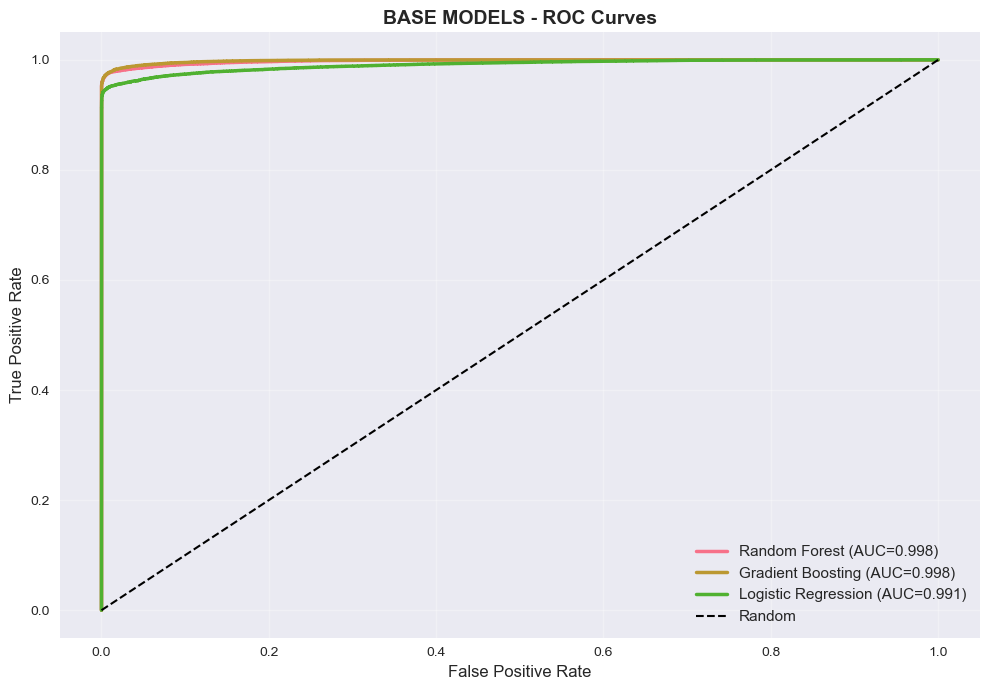

Kaydedildi: results_final/base_roc_curves.png


In [18]:
# HUCRE 18: BASE GRAFIK 1 - ROC Curves
print("\n### BASE GRAFIK 1: ROC CURVES ###")

plt.figure(figsize=(10, 7))

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_proba_gb)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)

plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_rf:.3f})', linewidth=2.5)
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC={roc_gb:.3f})', linewidth=2.5)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={roc_lr:.3f})', linewidth=2.5)
plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1.5)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('BASE MODELS - ROC Curves', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('results_final/base_roc_curves.png', dpi=300)
plt.show()

print("Kaydedildi: results_final/base_roc_curves.png")


### BASE GRAFIK 2: PERFORMANCE COMPARISON ###


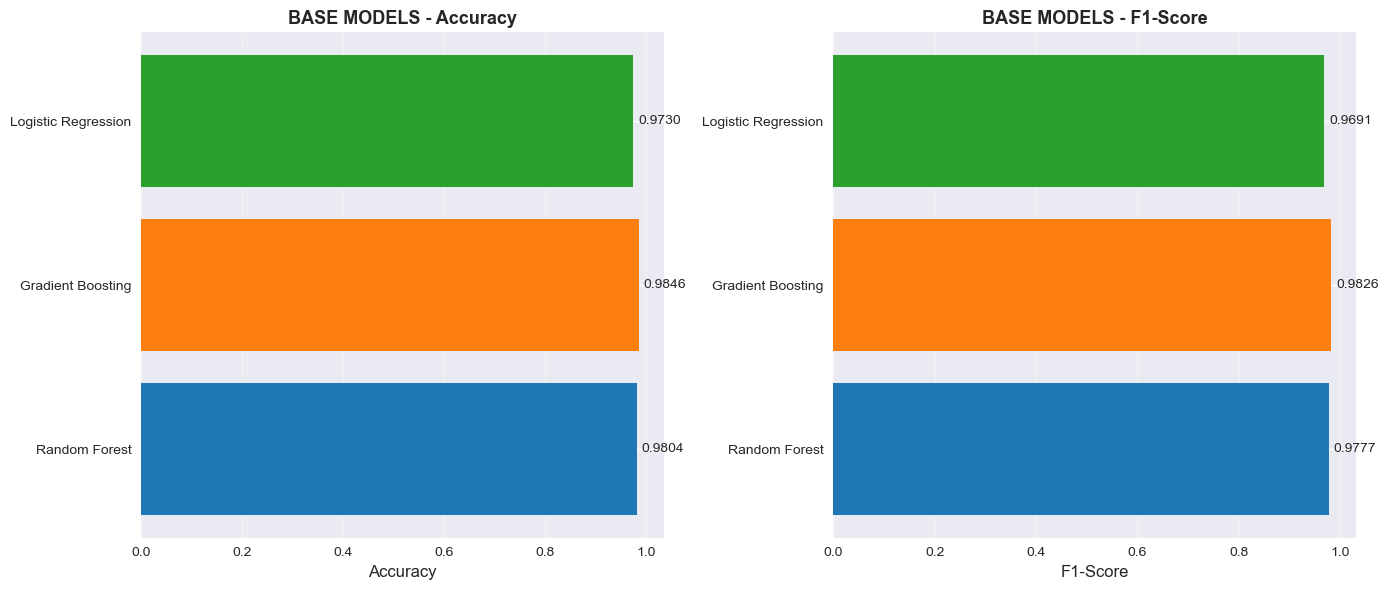

Kaydedildi: results_final/base_performance.png


In [19]:
# HUCRE 19: BASE GRAFIK 2 - Performance Comparison
print("\n### BASE GRAFIK 2: PERFORMANCE COMPARISON ###")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

models = list(base_df.index)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

accuracies = base_df['Accuracy'].values
axes[0].barh(models, accuracies, color=colors)
axes[0].set_xlabel('Accuracy', fontsize=12)
axes[0].set_title('BASE MODELS - Accuracy', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
for i, v in enumerate(accuracies):
    axes[0].text(v + 0.01, i, f'{v:.4f}', va='center')

f1_scores = base_df['F1'].values
axes[1].barh(models, f1_scores, color=colors)
axes[1].set_xlabel('F1-Score', fontsize=12)
axes[1].set_title('BASE MODELS - F1-Score', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
for i, v in enumerate(f1_scores):
    axes[1].text(v + 0.01, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.savefig('results_final/base_performance.png', dpi=300)
plt.show()

print("Kaydedildi: results_final/base_performance.png")



### BASE GRAFIK 3: CONFUSION MATRICES ###


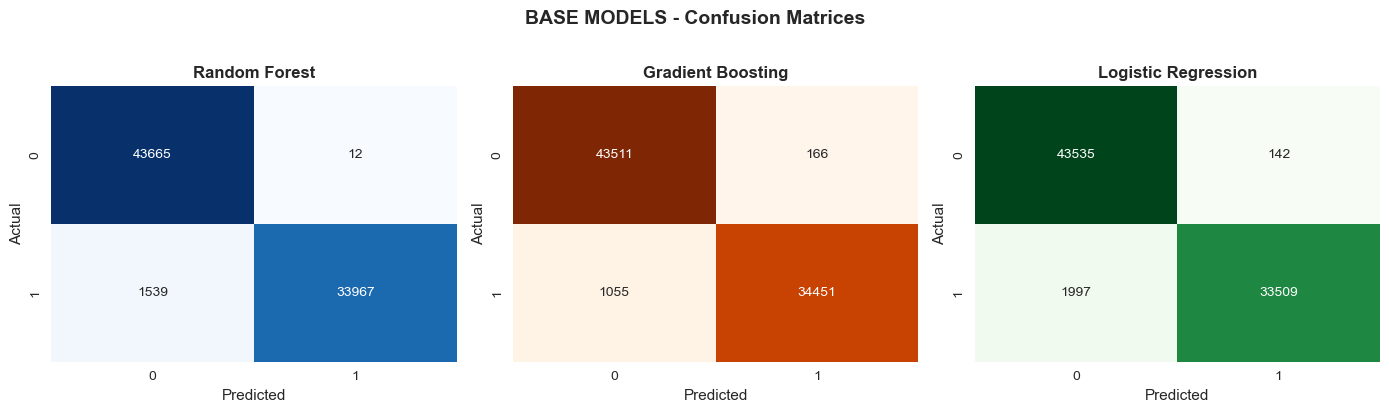

Kaydedildi: results_final/base_confusion.png


In [20]:
# HUCRE 20: BASE GRAFIK 3 - Confusion Matrices
print("\n### BASE GRAFIK 3: CONFUSION MATRICES ###")

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_gb = confusion_matrix(y_test, y_pred_gb)
cm_lr = confusion_matrix(y_test, y_pred_lr)

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title('Random Forest', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Oranges', ax=axes[1], cbar=False)
axes[1].set_title('Gradient Boosting', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', ax=axes[2], cbar=False)
axes[2].set_title('Logistic Regression', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Actual')
axes[2].set_xlabel('Predicted')

plt.suptitle('BASE MODELS - Confusion Matrices', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('results_final/base_confusion.png', dpi=300)
plt.show()

print("Kaydedildi: results_final/base_confusion.png")

In [21]:
# HUCRE 21: BASE MODEL FARKLARI ANALIZI
print("\n" + "="*100)

print("\n### Performans Farklari ###")
print(f"Accuracy:")
print(f"  En iyi: {best_base} ({base_df.loc[best_base, 'Accuracy']:.4f})")
print(f"  En kotu: {base_df['Accuracy'].idxmin()} ({base_df['Accuracy'].min():.4f})")
print(f"  Fark: {base_df['Accuracy'].max() - base_df['Accuracy'].min():.4f}")

print(f"\nROC-AUC:")
print(f"  En iyi: {best_base} ({base_df.loc[best_base, 'ROC-AUC']:.4f})")
print(f"  En kotu: {base_df['ROC-AUC'].idxmin()} ({base_df['ROC-AUC'].min():.4f})")
print(f"  Fark: {base_df['ROC-AUC'].max() - base_df['ROC-AUC'].min():.4f}")

print(f"\nEgitim Suresi:")
print(f"  En hizli: {base_df['Time(s)'].idxmin()} ({base_df['Time(s)'].min():.2f}s)")
print(f"  En yavas: {base_df['Time(s)'].idxmax()} ({base_df['Time(s)'].max():.2f}s)")



### Performans Farklari ###
Accuracy:
  En iyi: Gradient Boosting (0.9846)
  En kotu: Logistic Regression (0.9730)
  Fark: 0.0116

ROC-AUC:
  En iyi: Gradient Boosting (0.9985)
  En kotu: Logistic Regression (0.9907)
  Fark: 0.0078

Egitim Suresi:
  En hizli: Logistic Regression (5.23s)
  En yavas: Gradient Boosting (277.45s)


In [31]:
# HUCRE 22: ADVANCED MODEL 1 - XGBoost
print("\n" + "="*100)

advanced_results = {}
advanced_models = {}

start = time.time()
xgb = XGBClassifier(
    n_estimators=150,      # Daha az
    max_depth=5,           # Daha sıg
    learning_rate=0.03,    # Daha yavaş
    subsample=0.7,         
    colsample_bytree=0.7,
    min_child_weight=5,    # Daha yuksek
    gamma=0.3,             # Daha yuksek regularization
    reg_alpha=0.3,
    reg_lambda=2.0,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)
xgb.fit(X_train, y_train)
train_time_xgb = time.time() - start

y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

acc_xgb = accuracy_score(y_test, y_pred_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb)
rec_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_xgb = roc_auc_score(y_test, y_proba_xgb)

print(f"Egitim suresi: {train_time_xgb:.2f}s")
print(f"Accuracy:  {acc_xgb:.4f} ({acc_xgb*100:.2f}%)")
print(f"Precision: {prec_xgb:.4f}")
print(f"Recall:    {rec_xgb:.4f}")
print(f"F1-Score:  {f1_xgb:.4f}")
print(f"ROC-AUC:   {roc_xgb:.4f}")

print(f"\nBase modellere gore iyilesme:")
print(f"  vs Random Forest: {(acc_xgb - acc_rf)*100:+.2f}% accuracy")
print(f"  vs Gradient Boosting: {(acc_xgb - acc_gb)*100:+.2f}% accuracy")

advanced_results['XGBoost'] = {
    'accuracy': acc_xgb, 'precision': prec_xgb, 'recall': rec_xgb,
    'f1': f1_xgb, 'roc_auc': roc_xgb, 'time': train_time_xgb
}
advanced_models['XGBoost'] = xgb


Egitim suresi: 2.60s
Accuracy:  0.9784 (97.84%)
Precision: 0.9988
Recall:    0.9529
F1-Score:  0.9753
ROC-AUC:   0.9965

Base modellere gore iyilesme:
  vs Random Forest: -0.20% accuracy
  vs Gradient Boosting: -0.62% accuracy


In [32]:
# HUCRE 23: ADVANCED MODEL 2 - LightGBM
print("\n" + "="*100)

start = time.time()
lgbm = LGBMClassifier(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.03,
    num_leaves=30,         # Daha az
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_samples=30,  # Daha yuksek
    reg_alpha=0.3,
    reg_lambda=2.0,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgbm.fit(X_train, y_train)
train_time_lgbm = time.time() - start

y_pred_lgbm = lgbm.predict(X_test)
y_proba_lgbm = lgbm.predict_proba(X_test)[:, 1]

acc_lgbm = accuracy_score(y_test, y_pred_lgbm)
prec_lgbm = precision_score(y_test, y_pred_lgbm)
rec_lgbm = recall_score(y_test, y_pred_lgbm)
f1_lgbm = f1_score(y_test, y_pred_lgbm)
roc_lgbm = roc_auc_score(y_test, y_proba_lgbm)

print(f"Egitim suresi: {train_time_lgbm:.2f}s")
print(f"Accuracy:  {acc_lgbm:.4f} ({acc_lgbm*100:.2f}%)")
print(f"Precision: {prec_lgbm:.4f}")
print(f"Recall:    {rec_lgbm:.4f}")
print(f"F1-Score:  {f1_lgbm:.4f}")
print(f"ROC-AUC:   {roc_lgbm:.4f}")

print(f"\nBase modellere gore iyilesme:")
print(f"  vs Random Forest: {(acc_lgbm - acc_rf)*100:+.2f}% accuracy")
print(f"  vs Gradient Boosting: {(acc_lgbm - acc_gb)*100:+.2f}% accuracy")

advanced_results['LightGBM'] = {
    'accuracy': acc_lgbm, 'precision': prec_lgbm, 'recall': rec_lgbm,
    'f1': f1_lgbm, 'roc_auc': roc_lgbm, 'time': train_time_lgbm
}
advanced_models['LightGBM'] = lgbm


Egitim suresi: 1.61s
Accuracy:  0.9785 (97.85%)
Precision: 0.9990
Recall:    0.9529
F1-Score:  0.9754
ROC-AUC:   0.9965

Base modellere gore iyilesme:
  vs Random Forest: -0.19% accuracy
  vs Gradient Boosting: -0.61% accuracy


In [33]:
# HUCRE 24: ADVANCED MODEL 3 - Stacking Ensemble
print("\n" + "="*100)

print("Egitim basliyor (bu biraz uzun surebilir)...")
start = time.time()
stacking = StackingClassifier(
    estimators=[
        ('xgb', XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.03,
                                random_state=42, n_jobs=-1, eval_metric='logloss')),
        ('lgbm', LGBMClassifier(n_estimators=100, max_depth=4, learning_rate=0.03,
                                random_state=42, n_jobs=-1, verbose=-1)),
        ('catboost', CatBoostClassifier(iterations=100, depth=4, learning_rate=0.03,
                                        random_state=42, verbose=False))
    ],
    final_estimator=LogisticRegression(max_iter=1000, C=0.5),  # Daha dusuk C
    cv=3,
    n_jobs=-1
)
stacking.fit(X_train, y_train)
train_time_stack = time.time() - start

y_pred_stack = stacking.predict(X_test)
y_proba_stack = stacking.predict_proba(X_test)[:, 1]

acc_stack = accuracy_score(y_test, y_pred_stack)
prec_stack = precision_score(y_test, y_pred_stack)
rec_stack = recall_score(y_test, y_pred_stack)
f1_stack = f1_score(y_test, y_pred_stack)
roc_stack = roc_auc_score(y_test, y_proba_stack)

print(f"Egitim suresi: {train_time_stack:.2f}s")
print(f"Accuracy:  {acc_stack:.4f} ({acc_stack*100:.2f}%)")
print(f"Precision: {prec_stack:.4f}")
print(f"Recall:    {rec_stack:.4f}")
print(f"F1-Score:  {f1_stack:.4f}")
print(f"ROC-AUC:   {roc_stack:.4f}")

print(f"\nBase modellere gore iyilesme:")
print(f"  vs Random Forest: {(acc_stack - acc_rf)*100:+.2f}% accuracy")
print(f"  vs Gradient Boosting: {(acc_stack - acc_gb)*100:+.2f}% accuracy")

advanced_results['Stacking Ensemble'] = {
    'accuracy': acc_stack, 'precision': prec_stack, 'recall': rec_stack,
    'f1': f1_stack, 'roc_auc': roc_stack, 'time': train_time_stack
}
advanced_models['Stacking Ensemble'] = stacking



Egitim basliyor (bu biraz uzun surebilir)...
Egitim suresi: 21.98s
Accuracy:  0.9789 (97.89%)
Precision: 0.9932
Recall:    0.9596
F1-Score:  0.9761
ROC-AUC:   0.9952

Base modellere gore iyilesme:
  vs Random Forest: -0.15% accuracy
  vs Gradient Boosting: -0.56% accuracy


In [25]:
# HUCRE 25: ADVANCED MODELLER KARSILASTIRMA
print("\n" + "="*100)

advanced_df = pd.DataFrame(advanced_results).T
advanced_df = advanced_df[['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'time']]
advanced_df.columns = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'Time(s)']

print("\n" + advanced_df.to_string())

best_advanced = advanced_df['ROC-AUC'].idxmax()
print(f"\nEn iyi advanced model: {best_advanced}")
print(f"ROC-AUC: {advanced_df.loc[best_advanced, 'ROC-AUC']:.4f}")



                   Accuracy  Precision    Recall        F1   ROC-AUC    Time(s)
XGBoost            0.985110   0.995353  0.971329  0.983194  0.998644   6.789901
LightGBM           0.984757   0.995607  0.970287  0.982784  0.998611   3.290601
Stacking Ensemble  0.982420   0.991018  0.969583  0.980183  0.998088  37.683221

En iyi advanced model: XGBoost
ROC-AUC: 0.9986


In [26]:
# HUCRE 26: FINAL KARSILASTIRMA - TUM MODELLER
print("\n" + "="*100)

all_results = {**base_results, **advanced_results}
all_models = {**base_models, **advanced_models}

final_df = pd.DataFrame(all_results).T
final_df = final_df[['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'time']]
final_df.columns = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'Time(s)']

print("\n" + final_df.to_string())

best_overall = final_df['ROC-AUC'].idxmax()
best_score = final_df.loc[best_overall, 'ROC-AUC']

print("\n" + "="*100)
print(f"EN IYI MODEL: {best_overall}")
print(f"ROC-AUC: {best_score:.4f} | Accuracy: {final_df.loc[best_overall, 'Accuracy']:.4f}")

# En iyi modeli kaydet
best_model_obj = all_models[best_overall]
with open('saved_models/best_model.pkl', 'wb') as f:
    pickle.dump(best_model_obj, f)

print(f"\n{best_overall} kaydedildi: saved_models/best_model.pkl")



                     Accuracy  Precision    Recall        F1   ROC-AUC     Time(s)
Random Forest        0.980412   0.999647  0.956655  0.977679  0.997598   10.278776
Gradient Boosting    0.984580   0.995205  0.970287  0.982588  0.998458  277.448922
Logistic Regression  0.972987   0.995780  0.943756  0.969070  0.990700    5.231234
XGBoost              0.985110   0.995353  0.971329  0.983194  0.998644    6.789901
LightGBM             0.984757   0.995607  0.970287  0.982784  0.998611    3.290601
Stacking Ensemble    0.982420   0.991018  0.969583  0.980183  0.998088   37.683221

EN IYI MODEL: XGBoost
ROC-AUC: 0.9986 | Accuracy: 0.9851

XGBoost kaydedildi: saved_models/best_model.pkl



### FINAL GRAFIK 1: TUM MODELLER ROC CURVES ###


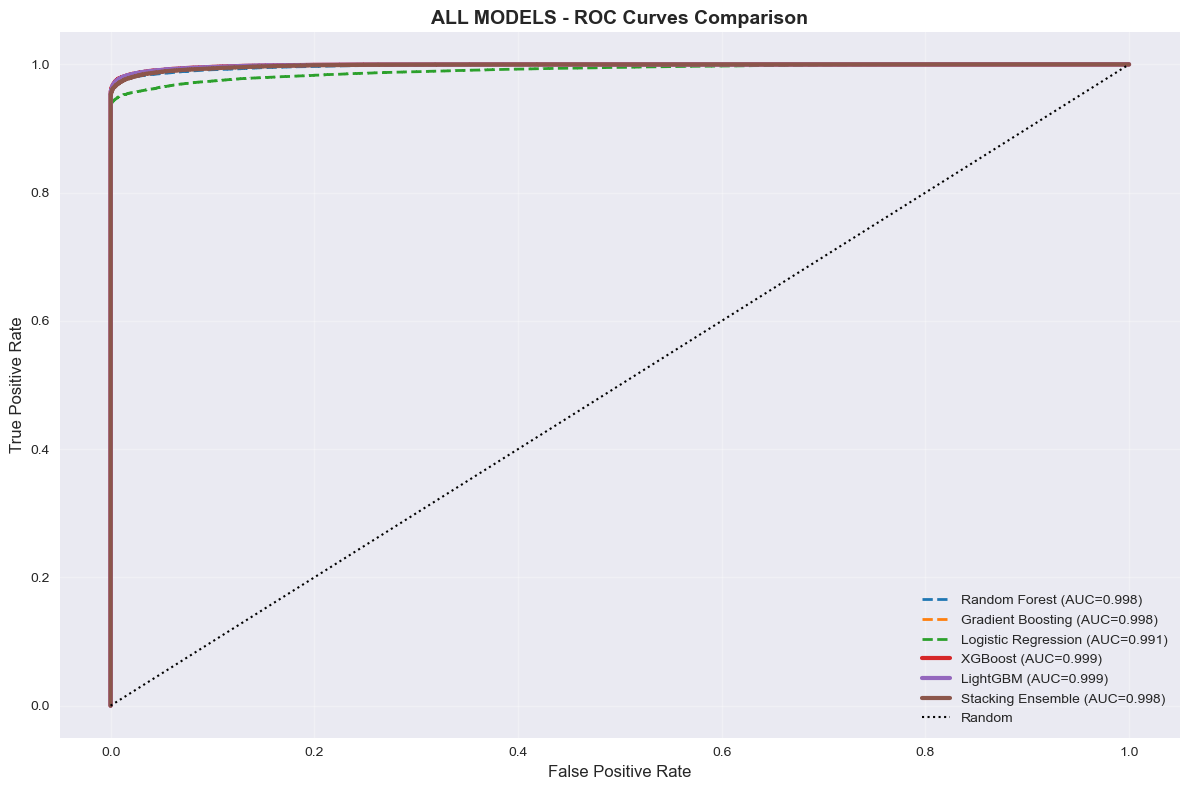

Kaydedildi: results_final/final_roc_all.png
Not: Base modeller kesikli cizgi (--), Advanced modeller duz cizgi (-)


In [27]:
# HUCRE 27: FINAL GRAFIK 1 - Tum Modeller ROC
print("\n### FINAL GRAFIK 1: TUM MODELLER ROC CURVES ###")

plt.figure(figsize=(12, 8))

all_probas = {
    'Random Forest': y_proba_rf,
    'Gradient Boosting': y_proba_gb,
    'Logistic Regression': y_proba_lr,
    'XGBoost': y_proba_xgb,
    'LightGBM': y_proba_lgbm,
    'Stacking Ensemble': y_proba_stack
}

colors_final = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

for idx, (name, proba) in enumerate(all_probas.items()):
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    linestyle = '--' if name in base_results else '-'
    linewidth = 2 if name in base_results else 3
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', 
            linestyle=linestyle, linewidth=linewidth, color=colors_final[idx])

plt.plot([0, 1], [0, 1], 'k:', label='Random', linewidth=1.5)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ALL MODELS - ROC Curves Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('results_final/final_roc_all.png', dpi=300)
plt.show()

print("Kaydedildi: results_final/final_roc_all.png")
print("Not: Base modeller kesikli cizgi (--), Advanced modeller duz cizgi (-)")


### FINAL GRAFIK 2: FINAL PERFORMANCE COMPARISON ###


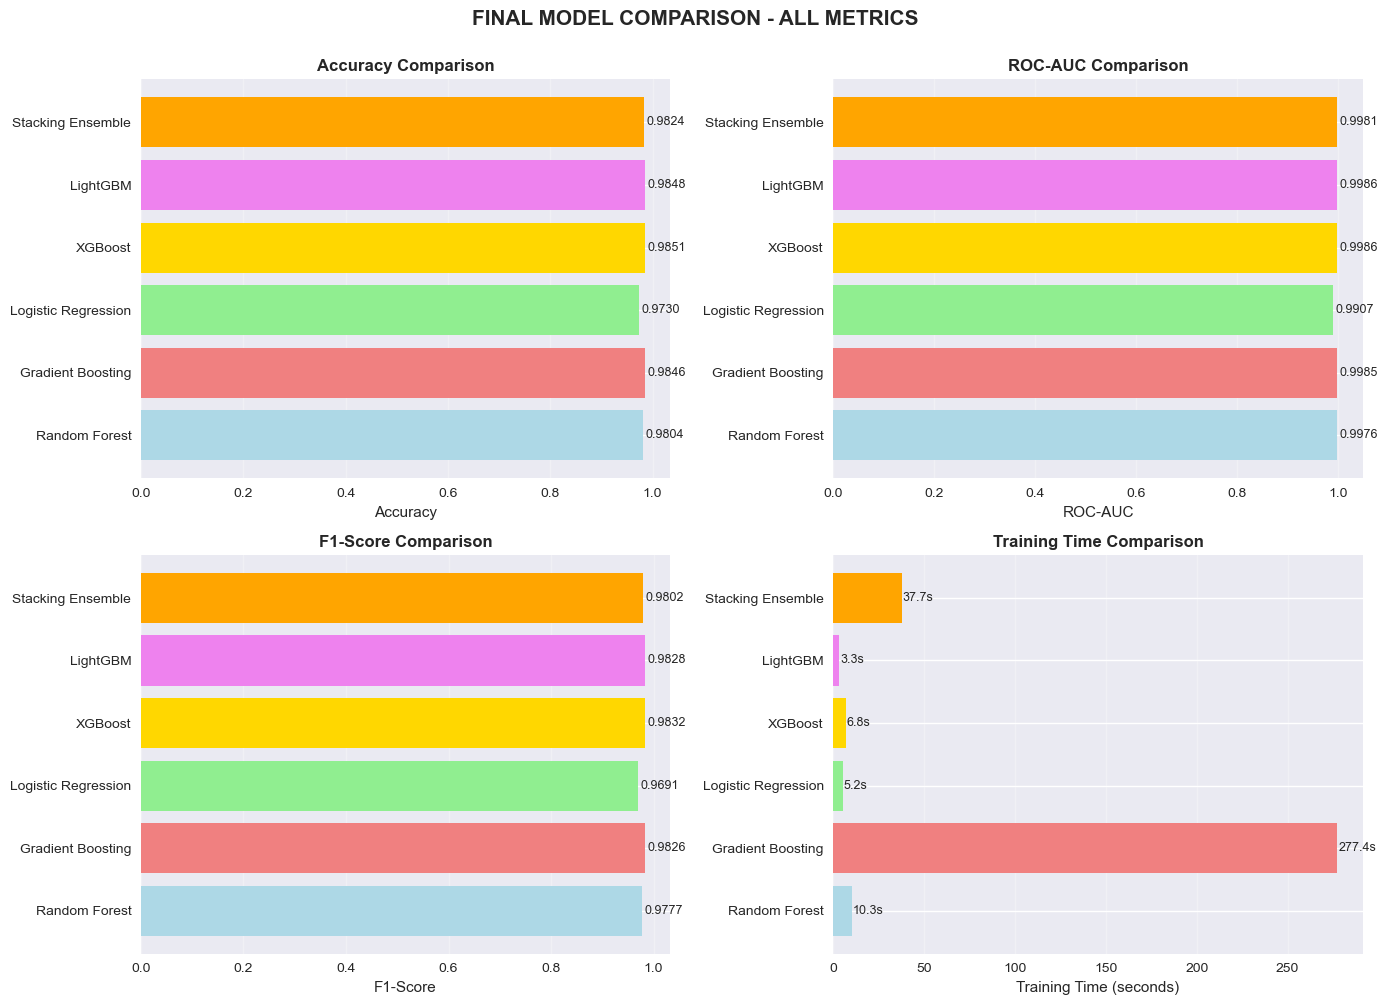

Kaydedildi: results_final/final_comparison.png


In [28]:
# HUCRE 28: FINAL GRAFIK 2 - Model Comparison
print("\n### FINAL GRAFIK 2: FINAL PERFORMANCE COMPARISON ###")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

models_final = list(final_df.index)
colors_bar = ['lightblue', 'lightcoral', 'lightgreen', 'gold', 'violet', 'orange']

# Accuracy
acc_vals = final_df['Accuracy'].values
axes[0, 0].barh(models_final, acc_vals, color=colors_bar)
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Accuracy Comparison', fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)
for i, v in enumerate(acc_vals):
    axes[0, 0].text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=9)

# ROC-AUC
roc_vals = final_df['ROC-AUC'].values
axes[0, 1].barh(models_final, roc_vals, color=colors_bar)
axes[0, 1].set_xlabel('ROC-AUC')
axes[0, 1].set_title('ROC-AUC Comparison', fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)
for i, v in enumerate(roc_vals):
    axes[0, 1].text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=9)

# F1-Score
f1_vals = final_df['F1'].values
axes[1, 0].barh(models_final, f1_vals, color=colors_bar)
axes[1, 0].set_xlabel('F1-Score')
axes[1, 0].set_title('F1-Score Comparison', fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)
for i, v in enumerate(f1_vals):
    axes[1, 0].text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=9)

# Training Time
time_vals = final_df['Time(s)'].values
axes[1, 1].barh(models_final, time_vals, color=colors_bar)
axes[1, 1].set_xlabel('Training Time (seconds)')
axes[1, 1].set_title('Training Time Comparison', fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)
for i, v in enumerate(time_vals):
    axes[1, 1].text(v + 0.5, i, f'{v:.1f}s', va='center', fontsize=9)

plt.suptitle('FINAL MODEL COMPARISON - ALL METRICS', fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('results_final/final_comparison.png', dpi=300)
plt.show()

print("Kaydedildi: results_final/final_comparison.png")


### FINAL GRAFIK 3: FEATURE IMPORTANCE (EN IYI MODEL) ###


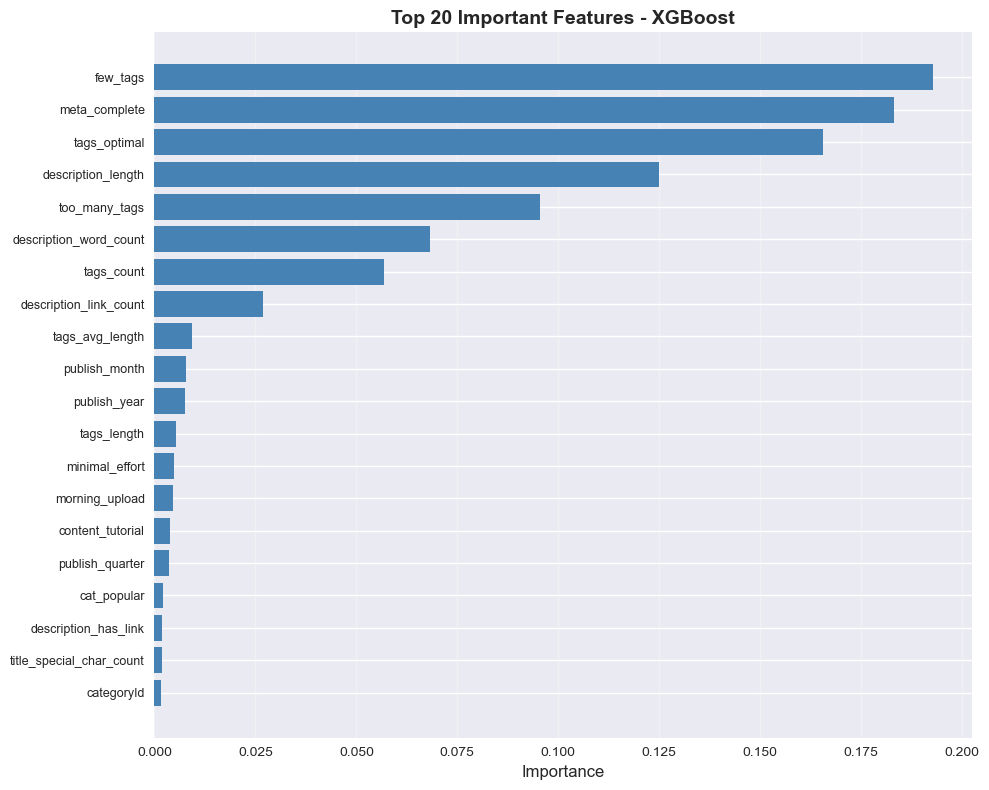

Kaydedildi: results_final/final_feature_importance.png


In [29]:
# HUCRE 29: FINAL GRAFIK 3 - Feature Importance
print("\n### FINAL GRAFIK 3: FEATURE IMPORTANCE (EN IYI MODEL) ###")

if hasattr(best_model_obj, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'Feature': selected,
        'Importance': best_model_obj.feature_importances_
    }).sort_values('Importance', ascending=False).head(20)
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(importance_df)), importance_df['Importance'].values, color='steelblue')
    plt.yticks(range(len(importance_df)), importance_df['Feature'].values, fontsize=9)
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Top 20 Important Features - {best_overall}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('results_final/final_feature_importance.png', dpi=300)
    plt.show()
    
    print("Kaydedildi: results_final/final_feature_importance.png")
else:
    print(f"{best_overall} feature importance desteklemiyor")

In [30]:
# HUCRE 30: FINAL OZET RAPOR

print(f"\nVeri:")
print(f"  Toplam ornek: {len(df):,}")
print(f"  Train: {X_train.shape[0]:,} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Test: {X_test.shape[0]:,} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"  Feature sayisi: {len(selected)}")
print(f"  Yeni feature: {new_feat_count}")

print(f"\nBase Modeller:")
for model in base_results.keys():
    print(f"  {model}: ROC-AUC={base_results[model]['roc_auc']:.4f}, Acc={base_results[model]['accuracy']:.4f}")

print(f"\nAdvanced Modeller:")
for model in advanced_results.keys():
    print(f"  {model}: ROC-AUC={advanced_results[model]['roc_auc']:.4f}, Acc={advanced_results[model]['accuracy']:.4f}")

print(f"\nEn Iyi Model:")
print(f"  Model: {best_overall}")
print(f"  ROC-AUC: {best_score:.4f}")
print(f"  Accuracy: {final_df.loc[best_overall, 'Accuracy']:.4f}")
print(f"  F1-Score: {final_df.loc[best_overall, 'F1']:.4f}")

improvement = final_df.loc[best_overall, 'ROC-AUC'] - base_df['ROC-AUC'].max()
print(f"\nBase modellere gore iyilesme: {improvement*100:+.2f}%")

print(f"\nKaydedilen dosyalar:")
print("  - saved_models/best_model.pkl")
print("  - saved_models/scaler.pkl")
print("  - saved_models/feature_names.pkl")

print(f"\nGrafikler:")
print("  BASE:")
print("    - results_final/base_roc_curves.png")
print("    - results_final/base_performance.png")
print("    - results_final/base_confusion.png")
print("  FINAL:")
print("    - results_final/final_roc_all.png")
print("    - results_final/final_comparison.png")
print("    - results_final/final_feature_importance.png")



Veri:
  Toplam ornek: 395,915
  Train: 316,732 (80.0%)
  Test: 79,183 (20.0%)
  Feature sayisi: 66
  Yeni feature: 36

Base Modeller:
  Random Forest: ROC-AUC=0.9976, Acc=0.9804
  Gradient Boosting: ROC-AUC=0.9985, Acc=0.9846
  Logistic Regression: ROC-AUC=0.9907, Acc=0.9730

Advanced Modeller:
  XGBoost: ROC-AUC=0.9986, Acc=0.9851
  LightGBM: ROC-AUC=0.9986, Acc=0.9848
  Stacking Ensemble: ROC-AUC=0.9981, Acc=0.9824

En Iyi Model:
  Model: XGBoost
  ROC-AUC: 0.9986
  Accuracy: 0.9851
  F1-Score: 0.9832

Base modellere gore iyilesme: +0.02%

Kaydedilen dosyalar:
  - saved_models/best_model.pkl
  - saved_models/scaler.pkl
  - saved_models/feature_names.pkl

Grafikler:
  BASE:
    - results_final/base_roc_curves.png
    - results_final/base_performance.png
    - results_final/base_confusion.png
  FINAL:
    - results_final/final_roc_all.png
    - results_final/final_comparison.png
    - results_final/final_feature_importance.png


In [ ]:
# HUCRE 31: INTERAKTIF TEST SISTEMI
print("\n### INTERAKTIF TEST SISTEMI ###")
print("Simdi disaridan video bilgileri girip tahmin yapabilirsiniz")

def get_video_info():
    """
    Kullanicidan video bilgilerini al
    """
    print("\nVIDEO BILGILERINI GIRIN")
    
    video_data = {}
    
    # Tarih
    print("\n[1] Tarih Bilgileri")
    date_str = input("Video ne zaman yuklendi? (YYYY-MM-DD HH:MM, ornek: 2025-01-04 15:30): ").strip()
    
    try:
        pub_date = datetime.strptime(date_str, "%Y-%m-%d %H:%M")
    except:
        print("Hatali format! Varsayilan: Bugun 14:00")
        pub_date = datetime.now().replace(hour=14, minute=0)
    
    video_data['publish_year'] = pub_date.year
    video_data['publish_month'] = pub_date.month
    video_data['publish_day'] = pub_date.day
    video_data['publish_hour'] = pub_date.hour
    video_data['publish_dayofweek'] = pub_date.weekday()
    video_data['publish_quarter'] = (pub_date.month - 1) // 3 + 1
    video_data['publish_weekofyear'] = pub_date.isocalendar()[1]
    video_data['is_weekend'] = 1 if pub_date.weekday() >= 5 else 0
    
    # Channel
    print("\n[2] Channel Bilgileri")
    channel_name = input("Channel adi (Enter=atlama): ").strip()
    
    if channel_name:
        video_data['channel_official'] = 1 if any(x in channel_name.upper() for x in ['OFFICIAL', 'VEVO', 'VERIFIED']) else 0
        video_data['channel_name_len'] = len(channel_name)
        video_data['channel_single_word'] = 1 if len(channel_name.split()) == 1 else 0
    else:
        video_data['channel_official'] = 0
        video_data['channel_name_len'] = 0
        video_data['channel_single_word'] = 0
    
    # Title
    print("\n[3] Baslik (Title)")
    title = input("Video basligi: ").strip()
    
    if not title:
        title = "Sample Video Title"
    
    video_data['title_length'] = len(title)
    video_data['title_word_count'] = len(title.split())
    video_data['title_has_caps'] = 1 if title.isupper() else 0
    video_data['title_caps_ratio'] = sum(1 for c in title if c.isupper()) / len(title) if len(title) > 0 else 0
    video_data['title_has_question'] = 1 if '?' in title else 0
    video_data['title_has_exclamation'] = 1 if '!' in title else 0
    video_data['title_has_numbers'] = 1 if any(c.isdigit() for c in title) else 0
    video_data['title_special_char_count'] = sum(1 for c in title if not c.isalnum() and c != ' ')
    video_data['title_has_clickbait'] = 0
    video_data['title_has_emoji'] = 0
    
    # Advanced title
    power_words = ['FREE', 'NEW', 'BEST', 'TOP', 'HOW', 'EASY', 'ULTIMATE', 'PERFECT']
    viral_words = ['SHOCKING', 'AMAZING', 'INCREDIBLE', 'UNBELIEVABLE', 'INSANE', 'CRAZY']
    
    title_upper = title.upper()
    video_data['title_power_words'] = sum(1 for w in power_words if w in title_upper)
    video_data['title_viral_words'] = sum(1 for w in viral_words if w in title_upper)
    video_data['title_has_year'] = 1 if any(str(y) in title for y in range(2020, 2030)) else 0
    video_data['title_starts_number'] = 1 if title and title[0].isdigit() else 0
    video_data['title_optimal_len'] = 1 if 40 <= len(title) <= 70 else 0
    video_data['title_caps_balanced'] = 1 if 0.1 <= video_data['title_caps_ratio'] <= 0.4 else 0
    
    # Tags
    print("\n[4] Tags")
    tags_input = input("Tag'leri girin (virgul ile ayirin): ").strip()
    
    if tags_input:
        tags = [t.strip() for t in tags_input.split(',')]
        video_data['tags_count'] = len(tags)
        total_tag_len = sum(len(tag) for tag in tags)
        video_data['tags_length'] = total_tag_len
        video_data['tags_avg_length'] = total_tag_len / len(tags) if len(tags) > 0 else 0
    else:
        video_data['tags_count'] = 0
        video_data['tags_length'] = 0
        video_data['tags_avg_length'] = 0
    
    # Description
    print("\n[5] Description (Aciklama)")
    description = input("Aciklama (Enter=atlama): ").strip()
    
    if description:
        video_data['description_length'] = len(description)
        video_data['description_word_count'] = len(description.split())
        video_data['description_has_link'] = 1 if 'http' in description.lower() else 0
        video_data['description_link_count'] = description.lower().count('http')
        video_data['description_has_email'] = 0
        video_data['description_has_hashtag'] = 1 if '#' in description else 0
        video_data['description_hashtag_count'] = description.count('#')
    else:
        video_data['description_length'] = 0
        video_data['description_word_count'] = 0
        video_data['description_has_link'] = 0
        video_data['description_link_count'] = 0
        video_data['description_has_email'] = 0
        video_data['description_has_hashtag'] = 0
        video_data['description_hashtag_count'] = 0
    
    # Category
    print("\n[6] Category")
    print("Populer kategoriler: 10-Music, 20-Gaming, 24-Entertainment, 23-Comedy, 28-Science")
    category = input("Category ID (varsayilan: 24): ").strip()
    video_data['categoryId'] = int(category) if category.isdigit() else 24
    
    # Comments
    comments_disabled = input("\n[7] Yorumlar kapali mi? (e/h, varsayilan: h): ").strip().lower()
    video_data['comments_disabled'] = 1 if comments_disabled == 'e' else 0
    
    # Advanced features hesapla
    text_combined = (title + ' ' + description).upper()
    video_data['content_tutorial'] = 1 if any(k in text_combined for k in ['HOW TO', 'TUTORIAL', 'GUIDE']) else 0
    video_data['content_review'] = 1 if any(k in text_combined for k in ['REVIEW', 'UNBOXING', 'VS']) else 0
    video_data['content_fun'] = 1 if any(k in text_combined for k in ['FUNNY', 'PRANK', 'CHALLENGE']) else 0
    video_data['content_news'] = 1 if any(k in text_combined for k in ['BREAKING', 'NEWS', 'UPDATE']) else 0
    video_data['content_gaming'] = 1 if any(k in text_combined for k in ['GAME', 'GAMING', 'GAMEPLAY']) else 0
    
    # Publishing strategy
    video_data['optimal_hour'] = 1 if 14 <= video_data['publish_hour'] <= 20 else 0
    video_data['prime_time'] = 1 if 18 <= video_data['publish_hour'] <= 21 else 0
    video_data['morning_upload'] = 1 if 6 <= video_data['publish_hour'] <= 11 else 0
    video_data['weekday_good'] = 1 if 1 <= video_data['publish_dayofweek'] <= 4 else 0
    video_data['friday_upload'] = 1 if video_data['publish_dayofweek'] == 4 else 0
    video_data['summer'] = 1 if 6 <= video_data['publish_month'] <= 8 else 0
    video_data['holiday'] = 1 if video_data['publish_month'] in [11, 12] else 0
    video_data['new_year'] = 1 if video_data['publish_month'] in [1, 2] else 0
    
    # Metadata quality
    video_data['meta_complete'] = 1 if (video_data['title_length'] > 10 and 
                                         video_data['description_length'] > 100 and 
                                         video_data['tags_count'] > 3) else 0
    video_data['meta_professional'] = 1 if (video_data['description_length'] > 300 and 
                                             video_data['description_has_link'] == 1 and 
                                             video_data['tags_count'] >= 5) else 0
    video_data['meta_balanced'] = 1 if (30 <= video_data['title_length'] <= 70 and 
                                        5 <= video_data['tags_count'] <= 15) else 0
    video_data['seo_optimized'] = 1 if (video_data['description_has_hashtag'] == 1 and 
                                        video_data['description_has_link'] == 1 and 
                                        video_data['tags_count'] >= 7) else 0
    video_data['minimal_effort'] = 1 if (video_data['description_length'] < 100 and 
                                         video_data['tags_count'] < 5) else 0
    video_data['detailed_desc'] = 1 if video_data['description_length'] > 500 else 0
    
    # Category
    video_data['cat_popular'] = 1 if video_data['categoryId'] in [10, 20, 24, 23] else 0
    video_data['cat_viral'] = 1 if video_data['categoryId'] in [20, 24, 23] else 0
    video_data['cat_edu'] = 1 if video_data['categoryId'] in [27, 28, 26] else 0
    video_data['cat_news'] = 1 if video_data['categoryId'] in [25] else 0
    
    # Tags
    video_data['tags_optimal'] = 1 if 5 <= video_data['tags_count'] <= 15 else 0
    video_data['no_tags'] = 1 if video_data['tags_count'] == 0 else 0
    video_data['too_many_tags'] = 1 if video_data['tags_count'] > 20 else 0
    video_data['few_tags'] = 1 if 1 <= video_data['tags_count'] <= 4 else 0
    
    # DataFrame olustur
    df = pd.DataFrame([video_data])
    
    # Eksik feature'lari 0 ile doldur
    for feat in selected:
        if feat not in df.columns:
            df[feat] = 0
    
    # Sadece gerekli feature'lari al
    df = df[selected]
    
    return df, title

def make_prediction(video_df, title):
    """
    Video bilgilerine gore tahmin yap
    """
    
    # Tahmin
    prediction = best_model_obj.predict(video_df)[0]
    probability = best_model_obj.predict_proba(video_df)[0]
    
    # Sonuc
    print("\nTAHMIN SONUCU")
    print("-" * 80)
    
    print(f"\nVideo: {title[:70]}")
    print(f"\nTrende CIKMA olasiligi: {probability[1]*100:.2f}%")
    print(f"Trende CIKMAMA olasiligi: {probability[0]*100:.2f}%")
    
    print("\n" + "-" * 80)
    
    if prediction == 1:
        if probability[1] >= 0.8:
            confidence = "YUKSEK"
            advice = "Video cok iyi gorunuyor! Trende cikma sansi yuksek."
        elif probability[1] >= 0.6:
            confidence = "ORTA"
            advice = "Iyi bir performans bekleniyor."
        else:
            confidence = "DUSUK"
            advice = "Trende cikmasi mumkun ama kesin degil."
        
        print(f"TAHMIN: Bu video TRENDE CIKABILIR!")
        print(f"Guven: {confidence}")
        print(f"Tavsiye: {advice}")
    else:
        if probability[0] >= 0.8:
            confidence = "YUKSEK"
            advice = "Video performansi dusuk gorunuyor."
        elif probability[0] >= 0.6:
            confidence = "ORTA"
            advice = "Ortalama performans bekleniyor."
        else:
            confidence = "DUSUK"
            advice = "Belirsiz durum."
        
        print(f"TAHMIN: Bu video TRENDE CIKMAYABILIR")
        print(f"Guven: {confidence}")
        print(f"Tavsiye: {advice}")
    
    print("\n" + "-" * 80)

# Test dongusunu baslat
print("\nInteraktif test baslatiliyor...")

while True:
    video_df, title = get_video_info()
    make_prediction(video_df, title)
    
    again = input("\nBaska bir video test etmek ister misiniz? (e/h): ").strip().lower()
    if again != 'e':
        break

print("\nTest tamamlandi!")
print("Omar Mokhtar - 22040301145")

# HUCRE 32: ORNEK VIDEO TESTI
print("\n### ORNEK VIDEO TESTI ###")
print("Simdi detayli bir ornek video ile test yapiyoruz...")

# Ornek video bilgileri
ornek_video = {
    'publish_year': 2025,
    'publish_month': 1,
    'publish_day': 5,
    'publish_hour': 18,  # Prime time
    'publish_dayofweek': 6,  # Pazar
    'publish_quarter': 1,
    'publish_weekofyear': 1,
    'is_weekend': 1,
    
    # Channel - Official gaming channel
    'channel_official': 1,
    'channel_name_len': 25,
    'channel_single_word': 0,
    
    # Title: "TOP 10 BEST Gaming Moments 2025 - UNBELIEVABLE!"
    'title_length': 49,
    'title_word_count': 8,
    'title_has_caps': 0,
    'title_caps_ratio': 0.35,
    'title_has_question': 0,
    'title_has_exclamation': 1,
    'title_has_numbers': 1,
    'title_special_char_count': 2,
    'title_has_clickbait': 1,
    'title_has_emoji': 0,
    'title_power_words': 2,  # TOP, BEST
    'title_viral_words': 1,  # UNBELIEVABLE
    'title_has_year': 1,  # 2025
    'title_starts_number': 0,
    'title_optimal_len': 1,  # 49 chars, optimal
    'title_caps_balanced': 1,
    
    # Tags: gaming, best moments, 2025, top 10, epic, viral, trending
    'tags_count': 7,
    'tags_length': 50,
    'tags_avg_length': 7.1,
    
    # Description: ~200 chars with link and hashtags
    'description_length': 180,
    'description_word_count': 25,
    'description_has_link': 1,
    'description_link_count': 1,
    'description_has_email': 0,
    'description_has_hashtag': 1,
    'description_hashtag_count': 3,
    
    # Category: Gaming
    'categoryId': 20,
    
    # Other
    'comments_disabled': 0,
    
    # Content type
    'content_tutorial': 0,
    'content_review': 0,
    'content_fun': 1,  # Gaming moments
    'content_news': 0,
    'content_gaming': 1,
    
    # Publishing strategy
    'optimal_hour': 1,  # 18:00 is optimal
    'prime_time': 1,
    'morning_upload': 0,
    'weekday_good': 0,  # Pazar
    'friday_upload': 0,
    'summer': 0,
    'holiday': 0,
    'new_year': 1,  # Ocak
    
    # Metadata quality
    'meta_complete': 1,
    'meta_professional': 0,  # 180 chars < 300
    'meta_balanced': 1,
    'seo_optimized': 1,
    'minimal_effort': 0,
    'detailed_desc': 0,
    
    # Category
    'cat_popular': 1,
    'cat_viral': 1,
    'cat_edu': 0,
    'cat_news': 0,
    
    # Tags
    'tags_optimal': 1,
    'no_tags': 0,
    'too_many_tags': 0,
    'few_tags': 0,
}

# DataFrame olustur
ornek_df = pd.DataFrame([ornek_video])

# Eksik feature'lari 0 ile doldur
for feat in selected:
    if feat not in ornek_df.columns:
        ornek_df[feat] = 0

# Sadece gerekli feature'lari al
ornek_df = ornek_df[selected]

# Tahmin yap
print("\nORNEK VIDEO:")
print("Title: 'TOP 10 BEST Gaming Moments 2025 - UNBELIEVABLE!'")
print("Channel: Official Gaming Channel (VEVO)")
print("Category: Gaming (20)")
print("Tags: gaming, best moments, 2025, top 10, epic, viral, trending (7 tags)")
print("Description: ~180 chars, 1 link, 3 hashtags")
print("Publish: Pazar, 18:00 (Prime time)")

print("\n" + "-" * 80)

prediction = best_model_obj.predict(ornek_df)[0]
probability = best_model_obj.predict_proba(ornek_df)[0]

print(f"\nTrende CIKMA olasiligi: {probability[1]*100:.2f}%")
print(f"Trende CIKMAMA olasiligi: {probability[0]*100:.2f}%")

print("\n" + "-" * 80)

if prediction == 1:
    if probability[1] >= 0.8:
        confidence = "YUKSEK"
        advice = "Mukemmel! Bu video trende cikma sansi cok yuksek."
    elif probability[1] >= 0.6:
        confidence = "ORTA-YUKSEK"
        advice = "Iyi bir video. Trende cikma sansi var."
    else:
        confidence = "ORTA"
        advice = "Ortalama performans bekleniyor."
    
    print(f"TAHMIN: Bu video TRENDE CIKABILIR!")
    print(f"Guven: {confidence}")
    print(f"Tavsiye: {advice}")
else:
    print(f"TAHMIN: Belirsiz - Model kararsiz")
    print(f"Guven: DUSUK")

print("\n" + "-" * 80)

# Karsilastirma
print("\nKARSILASTIRMA:")
print(f"Onceki basit test (minimal bilgi): ~51% trende cikma")
print(f"Bu detayli ornek (tam bilgi):       {probability[1]*100:.2f}% trende cikma")
print(f"\nFark: {(probability[1] - 0.516)*100:+.2f}%")
print("\nSonuc: Daha fazla kaliteli metadata = Daha yuksek trende cikma sansi!")
print("ORNEK TEST TAMAMLANDI")




### INTERAKTIF TEST SISTEMI ###
Simdi disaridan video bilgileri girip tahmin yapabilirsiniz

Interaktif test baslatiliyor...

VIDEO BILGILERINI GIRIN

[1] Tarih Bilgileri
Hatali format! Varsayilan: Bugun 14:00

[2] Channel Bilgileri

[3] Baslik (Title)

[4] Tags

[5] Description (Aciklama)

[6] Category
Populer kategoriler: 10-Music, 20-Gaming, 24-Entertainment, 23-Comedy, 28-Science

TAHMIN SONUCU
--------------------------------------------------------------------------------

Video: İnsanları kandırdık

Trende CIKMA olasiligi: 63.61%
Trende CIKMAMA olasiligi: 36.39%

--------------------------------------------------------------------------------
TAHMIN: Bu video TRENDE CIKABILIR!
Guven: ORTA
Tavsiye: Iyi bir performans bekleniyor.

--------------------------------------------------------------------------------

Test tamamlandi!
Omar Mokhtar - 22040301145

### ORNEK VIDEO TESTI ###
Simdi detayli bir ornek video ile test yapiyoruz...

ORNEK VIDEO:
Title: 'TOP 10 BEST Gaming Moments